# Baseline Modelle

In [57]:
#Laden der benötigten Bibliotheken
import pandas as pd
import numpy as np
import nltk   #Natural Language ToolKit
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Daten einlesen


In [58]:
data = pd.read_csv("D:/NLPCourse/Biontech.csv")

In [59]:
data["basic_sentiment"].value_counts()

0.0    3833
1.0     147
Name: basic_sentiment, dtype: int64

In [60]:
data.head()

,created_at,id,username,name,user_id,body,basic_sentiment
0,2021-12-31 23:32:20+00:00,422493745,Witstock,Colin Robinson,3315545,$MRNA $bntx RIP Betty…$spy $qqq $pfe,0.0
1,2021-12-31 23:26:39+00:00,422492859,15HY,ARN,5380284,$BNTX $PFE https://ig.ft.com/coronavirus-vacci...,0.0
2,2021-12-31 23:00:54+00:00,422488662,academyofstocks,Academy of Stocks,546853,Oversold stocks to buy in 2022 using DCF \n\n$...,NaN
3,2021-12-31 21:48:45+00:00,422473776,BiotechMike141,Michael Stewart,5453342,$BNTX Happy new year longs!!,0.0
4,2021-12-31 21:38:43+00:00,422471365,Witstock,Colin Robinson,3315545,@Poundsand07 another ancient aliens quack you ...,0.0


## Pre-Processing

In [61]:
#lower case
#data["tweets_preproc"] = data["body"].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

In [62]:
#html tags und urls raus
from bs4 import BeautifulSoup
data["tweets_preproc"]=data["body"].apply(lambda x: BeautifulSoup(x).get_text())
import re
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: re.sub(r"http\S+", "", x))

In [63]:
#kontrahieren: don't -> do not etc.
#def contractions(s):
# s = re.sub(r"won’t", "will not",s)
# s = re.sub(r"would’t", "would not",s)
# s = re.sub(r"could’t", "could not",s)
# s = re.sub(r"\’d", " would",s)
# s = re.sub(r"can\’t", "can not",s)
# s = re.sub(r"n\’t", " not", s)
# s= re.sub(r"\’re", " are", s)
# s = re.sub(r"\’s", " is", s)
# s = re.sub(r"\’ll", " will", s)
# s = re.sub(r"\’t", " not", s)
# s = re.sub(r"\’ve", " have", s)
# s = re.sub(r"\’m", " am", s)
# return s
#data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x:contractions(x))

In [64]:
#sonderzeichen etc. raus
#Ressourcen downloaden
#nltk.download('punkt')
#sonderzeichen etc. raus
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

In [65]:
#überschüssige leerzeichen raus
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: re.sub(' +', ' ', x))

In [66]:
#fehlende Ressourcen downloaden
#nltk.download('stopwords')
#stopwords raus
#from nltk.corpus import stopwords
#stop = stopwords.words('english')
#data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

In [67]:
#lemmatization
#nltk.download('wordnet')
#from nltk.stem import WordNetLemmatizer
#lemmatizer = WordNetLemmatizer()
#data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

In [68]:
#Datumsvariable erstellen - um ggf. spaeter Ergebnisse zu plotten
data["created_at"] = pd.to_datetime(data.created_at, format='%Y-%m-%d %H:%M:%S')
data['date'] = data['created_at'].dt.strftime('%m/%d/%Y')

In [69]:
#Prüfen, ob alles geklappt hat
data.head()

,created_at,id,username,name,user_id,body,basic_sentiment,tweets_preproc,date
0,2021-12-31 23:32:20+00:00,422493745,Witstock,Colin Robinson,3315545,$MRNA $bntx RIP Betty…$spy $qqq $pfe,0.0,MRNA bntx RIP Betty spy qqq pfe,12/31/2021
1,2021-12-31 23:26:39+00:00,422492859,15HY,ARN,5380284,$BNTX $PFE https://ig.ft.com/coronavirus-vacci...,0.0,BNTX PFE,12/31/2021
2,2021-12-31 23:00:54+00:00,422488662,academyofstocks,Academy of Stocks,546853,Oversold stocks to buy in 2022 using DCF \n\n$...,NaN,Oversold stocks to buy in using DCF BABA BNTX ...,12/31/2021
3,2021-12-31 21:48:45+00:00,422473776,BiotechMike141,Michael Stewart,5453342,$BNTX Happy new year longs!!,0.0,BNTX Happy new year longs,12/31/2021
4,2021-12-31 21:38:43+00:00,422471365,Witstock,Colin Robinson,3315545,@Poundsand07 another ancient aliens quack you ...,0.0,Poundsand another ancient aliens quack you gu...,12/31/2021


In [70]:
#Datensatz nur mit gelabelten Tweets
data_labeled = data.dropna(subset = ["basic_sentiment"])
data_labeled = data_labeled.reset_index(drop=True)

In [71]:
#nicht gelabelte Tweets für spätere Anwendungen
data_unlabeled = data[data["basic_sentiment"].isnull()]

## Sentiment Analysis

### 1 - VADER

Vorteile:
- Braucht kein Training
- Funktioniert ohne gelabelte Daten
- speziell für Social Media (unterscheidet z.B. TOLL - toll - toll!)

Nachteile:
- Liefert teilweise keine optimalen Ergebnisse
- Hat drei Klassen (neg/neutr/pos), Tweets haben nur zwei

In [72]:
#download vader lexikon (scheint in nltk zu fehlen (vllt. auch Problem mit anderem vader?))
#nltk.download('vader_lexicon')
#nltk vader
sid = SentimentIntensityAnalyzer()
#model
data_labeled["v_scores"] = data_labeled["tweets_preproc"].apply(lambda body: sid.polarity_scores(body))

In [73]:
#eigene Spalte für scores erstellen
data_labeled['compound']  = data_labeled['v_scores'].apply(lambda score_dict: score_dict['compound'])

In [74]:
#Predictions
data_labeled['v_sentiment'] = (
    np.where(
        data_labeled['compound'] > 0.05,0,
        np.where(data_labeled['compound'] < -0.05, 1, -99)))

In [75]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm_vader = confusion_matrix(data_labeled["basic_sentiment"], data_labeled["v_sentiment"])

[Text(0, 0.5, 'neutral'), Text(0, 1.5, 'positive'), Text(0, 2.5, 'negative')]

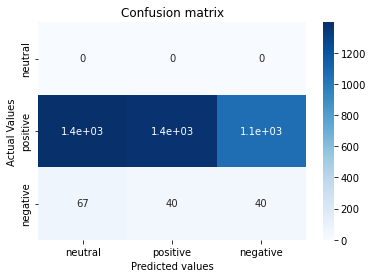

In [76]:
import seaborn as sns
ax = sns.heatmap(cm_vader, annot=True, cmap = 'Blues')
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['neutral','positive','negative'])
ax.yaxis.set_ticklabels(['neutral','positive','negative'])

### 2 - TF - IDF

Term-frequency - inverse document-frequency: $tf-idf(t,d) = tf(t,d) * idf(t)$ </br>
tf = Anzahl eines Wortes $t$ in einem Tweet/Dokument </br>
$idf(t) = log\frac{n}{1+df(t)}$ (sklearn weicht leicht von Standardformulierung ab)</br>
mit $n$ = Anzahl aller Tweets im Datensatz, $df(t)$ = Anzahl aller Tweets, die Wort $t$ enthalten. </br>
Tf-idf wird zusätzlich normalisiert: </br>
$v_{norm} = \frac{v}{||v||_{2}} = \frac{v}{\sqrt{v_{1}² + v_{2}² + ... + v_{n}²}}$ </br>

In [77]:
#train / test split mit gleichen Anteilen der Klassen in Trainings- und Testdaten
from sklearn.model_selection import train_test_split
baseline_train,baseline_test = train_test_split(data_labeled,
                                                  stratify = data_labeled["basic_sentiment"],
                                                  test_size=0.1, random_state=42)
print("Training Set: ",baseline_train.shape, "Test Set: ",baseline_test.shape)

Training Set:  (3582, 12) Test Set:  (398, 12)


In [78]:
baseline_train["basic_sentiment"].value_counts()

0.0    3450
1.0     132
Name: basic_sentiment, dtype: int64

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), norm="l2")
vectorizer.fit(baseline_train["tweets_preproc"])
tf_x_train = vectorizer.transform(baseline_train["tweets_preproc"])
tf_x_test = vectorizer.transform(baseline_test["tweets_preproc"])

In [80]:
#pd.DataFrame.sparse.from_spmatrix(tf_x_train)

In [81]:
tf_x_test

<398x62478 sparse matrix of type '<class 'numpy.float64'>'
	with 13748 stored elements in Compressed Sparse Row format>

In [82]:
#SVM classifier
#ohne grid search
from sklearn import svm
svm = svm.SVC(class_weight={1:96.3, 0:3.7})

In [83]:
#fitten
svm.fit(tf_x_train, baseline_train["basic_sentiment"])

SVC(class_weight={0: 3.7, 1: 96.3})

In [84]:
#predictions
y_fit_svm_base = svm.predict(tf_x_test)
baseline_test["sentiment_svm_base"] = y_fit_svm_base

In [85]:
#ergebnisse /modellgüte
from sklearn.metrics import classification_report
svm_results_base = classification_report(baseline_test["basic_sentiment"], y_fit_svm_base, output_dict = True)

In [86]:
svm_results_base

{'0.0': {'precision': 0.96875,
  'recall': 0.9712793733681462,
  'f1-score': 0.9700130378096479,
  'support': 383},
 '1.0': {'precision': 0.21428571428571427,
  'recall': 0.2,
  'f1-score': 0.20689655172413796,
  'support': 15},
 'accuracy': 0.9422110552763819,
 'macro avg': {'precision': 0.5915178571428571,
  'recall': 0.5856396866840731,
  'f1-score': 0.5884547947668929,
  'support': 398},
 'weighted avg': {'precision': 0.9403154163675521,
  'recall': 0.9422110552763819,
  'f1-score': 0.9412523662235106,
  'support': 398}}

In [87]:
#Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'C': np.logspace(-3, 2, 6), 'kernel': ['linear']},
  {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), 'kernel': ['rbf']},
 ]

grid_search = GridSearchCV(svm, param_grid, n_jobs = -1, verbose = 2)
grid_search.fit(tf_x_train, baseline_train["basic_sentiment"])

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(estimator=SVC(class_weight={0: 3.7, 1: 96.3}), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['linear']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['rbf']}],
             verbose=2)

In [88]:
print(grid_search.best_params_)

{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}


In [89]:
#Bestes Modell auf Testdaten anwenden und fitted values speichern
model_svm = grid_search.best_estimator_
y_fit_svm = model_svm.predict(tf_x_test)
baseline_test["sentiment_svm"] = y_fit_svm

In [90]:
#ergebnisse /modellgüte
svm_results=classification_report(baseline_test["basic_sentiment"], y_fit_svm,output_dict=True)

C:\Anaconda3\envs\NLPCourse\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\NLPCourse\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\NLPCourse\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
cm_svm = confusion_matrix(baseline_test["basic_sentiment"], y_fit_svm)

[Text(0, 0.5, 'positive'), Text(0, 1.5, 'negative')]

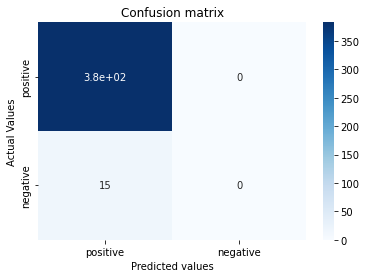

In [92]:
ax = sns.heatmap(cm_svm, annot=True, cmap = 'Blues')
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['positive','negative'])
ax.yaxis.set_ticklabels(['positive','negative'])

In [93]:
svm_results

{'0.0': {'precision': 0.9623115577889447,
  'recall': 1.0,
  'f1-score': 0.9807938540332907,
  'support': 383},
 '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15},
 'accuracy': 0.9623115577889447,
 'macro avg': {'precision': 0.48115577889447236,
  'recall': 0.5,
  'f1-score': 0.49039692701664533,
  'support': 398},
 'weighted avg': {'precision': 0.9260435342541855,
  'recall': 0.9623115577889447,
  'f1-score': 0.9438292615445988,
  'support': 398}}

   precision = tp / (tp + fp) </br>
   recall / sensitivity = tp / (tp + fn) </br>
   F1 = 2 * (precision * recall) / (precision + recall)

In [94]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#Base model
rf = RandomForestClassifier(random_state = 42, class_weight={1:96.3, 0:3.7})

In [95]:
#fit base model
rf.fit(tf_x_train, baseline_train["basic_sentiment"])

RandomForestClassifier(class_weight={0: 3.7, 1: 96.3}, random_state=42)

In [96]:
#predictions
y_fit_rf_base = rf.predict(tf_x_test)
baseline_test["sentiment_rf"] = y_fit_rf_base

In [97]:
#ergebnisse /modellgüte
rf_results=classification_report(baseline_test["basic_sentiment"], y_fit_rf_base,output_dict=True)

In [98]:
rf_results

{'0.0': {'precision': 0.96875,
  'recall': 0.9712793733681462,
  'f1-score': 0.9700130378096479,
  'support': 383},
 '1.0': {'precision': 0.21428571428571427,
  'recall': 0.2,
  'f1-score': 0.20689655172413796,
  'support': 15},
 'accuracy': 0.9422110552763819,
 'macro avg': {'precision': 0.5915178571428571,
  'recall': 0.5856396866840731,
  'f1-score': 0.5884547947668929,
  'support': 398},
 'weighted avg': {'precision': 0.9403154163675521,
  'recall': 0.9422110552763819,
  'f1-score': 0.9412523662235106,
  'support': 398}}

## Ergebnisse plotten

kurzer Versuch, die Predictions zu aggregieren, daraus einen Sentiment Score für einen Tag zu berechnen und diesen zu plotten

In [99]:
baseline_test2 = baseline_test

In [100]:
baseline_test["basic_sentiment"] = (np.where((baseline_test["basic_sentiment"] == 0) ,0,1))

In [101]:
baseline_test["sentiment_svm"] = (np.where((baseline_test["sentiment_svm_base"] == 0),0,1))

In [102]:
#function to create dummy variables and add them to the dataframe
def dummies(dataframe, columns):
    dummy_df = pd.get_dummies(data = dataframe, columns = columns, dtype = np.float64)
    return dummy_df

In [103]:
dummy_vars = ['basic_sentiment','sentiment_svm','v_sentiment']
baseline_test = dummies(baseline_test, dummy_vars)

In [104]:
#aggregation
sentiment_scores_test = baseline_test.groupby("date").agg({'basic_sentiment_1': sum,
                                                           'basic_sentiment_0': sum,
                                                           'sentiment_svm_1': sum,
                                                           'sentiment_svm_0':sum,
                                                          'v_sentiment_0':sum,
                                                          'v_sentiment_1':sum,
                                                          'v_sentiment_-99':sum})                                          
                                                           

In [105]:
def sentiment_score(pos,neg):
    avg_score = (pos - neg) / (pos + neg)
    return avg_score

In [106]:
def sentiment_vader(pos,neg,neutr):
    avg_score = (pos - neg) / (pos + neg + neutr)
    return avg_score

In [107]:
sentiment_scores_test["basic"] = sentiment_score(sentiment_scores_test["basic_sentiment_0"], sentiment_scores_test["basic_sentiment_1"])
sentiment_scores_test["predicted"] = sentiment_score(sentiment_scores_test["sentiment_svm_0"], sentiment_scores_test["sentiment_svm_1"])
sentiment_scores_test["vader"] = sentiment_vader(sentiment_scores_test["v_sentiment_0"], sentiment_scores_test["v_sentiment_1"], sentiment_scores_test["v_sentiment_-99"])

In [108]:
#create date variable from index
sentiment_scores_test["date"] = sentiment_scores_test.index

In [109]:
sentiment_scores_test["date"] = pd.to_datetime(sentiment_scores_test.date, format='%m/%d/%Y')

In [110]:
#plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
%matplotlib inline

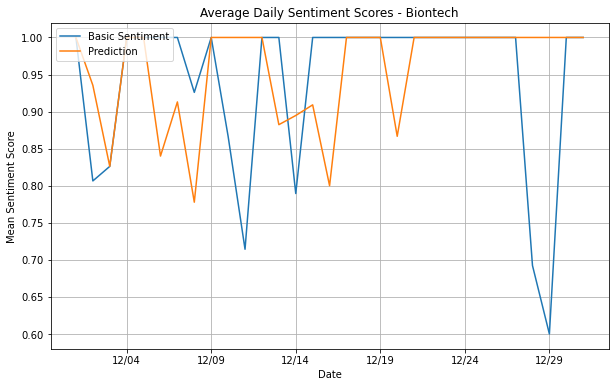

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sentiment_scores_test["date"],sentiment_scores_test.basic, label = 'Basic Sentiment')
ax.plot(sentiment_scores_test["date"], sentiment_scores_test["predicted"], label = 'Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Sentiment Score')
ax.set_title('Average Daily Sentiment Scores - Biontech')
ax.grid(True)
ax.legend(loc='upper left');

#format date axis
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
#change interval 
ax.xaxis.set_major_locator(ticker.AutoLocator())

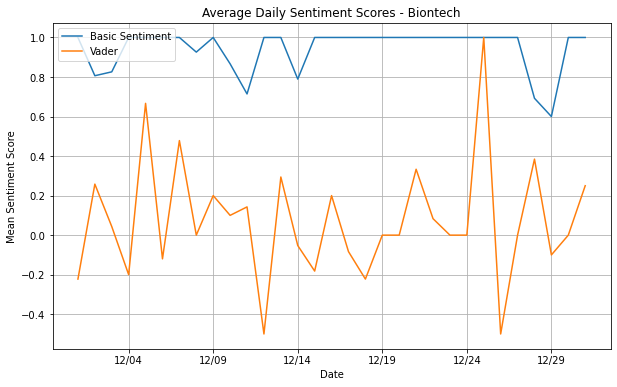

In [112]:
#Zum Vergleich VADER
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sentiment_scores_test["date"],sentiment_scores_test.basic, label = 'Basic Sentiment')
ax.plot(sentiment_scores_test["date"], sentiment_scores_test["vader"], label = 'Vader')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Sentiment Score')
ax.set_title('Average Daily Sentiment Scores - Biontech')
ax.grid(True)
ax.legend(loc='upper left');

#format date axis
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
#change interval 
ax.xaxis.set_major_locator(ticker.AutoLocator())